In [19]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorboard
import torch as th
from scipy import stats

from copy import deepcopy

from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
import stable_baselines3

from stochastic.processes.continuous import BrownianMotion, GeometricBrownianMotion, BesselProcess, BrownianBridge, BrownianMeander
from stochastic.processes.diffusion import ConstantElasticityVarianceProcess

import sys
sys.path.append("../") # <-- Path to the main repo

from main.agents.Agent import Agent
from main.agents.AvellanedaStoikovAgent import AvellanedaStoikovAgent
from main.agents.BaselineAgents import RandomAgent, FixedSpreadAgent
from main.agents.SBAgent import SBAgent
from main.gym.ModelBasedEnvironment import ModelBasedEnvironment
from main.gym.models import *
from main.gym.wrappers import *
from main.gym.AvellanedaStoikovEnvironment import AvellanedaStoikovEnvironment
from main.gym.helpers.generate_trajectory import generate_trajectory
from main.rewards.RewardFunctions import InventoryAdjustedPnL
from main.gym.helpers.plotting import plot_stable_baselines_actions

In [20]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Investigating the expected rewards of fixed strategies by sampling

In [21]:
terminal_time = 1.0
n_steps = 100
timestamps = np.linspace(0, terminal_time, n_steps + 1)
env_params = dict(terminal_time=terminal_time, n_steps=n_steps, max_half_spread = 1)
as_env = AvellanedaStoikovEnvironment(**env_params)
reduced_env = ReduceStateSizeWrapper(as_env)

gym.envs.register(id="as-env-v0", entry_point="__main__:AvellanedaStoikovEnvironment", kwargs=env_params)

In [22]:
N_EPISODES = 200
def fixed_strat_neg_reward(half_spread:float, env:gym.Env=reduced_env):
    total_rewards = 0
    for _ in range(N_EPISODES):
        _,_,episode_rewards = generate_trajectory(env,FixedSpreadAgent(half_spread))
        total_rewards+= sum(episode_rewards)
    return -total_rewards/N_EPISODES    

In [23]:
fixed_spread_rewards = [-fixed_strat_neg_reward(hs) for hs in np.linspace(0,2,200)]

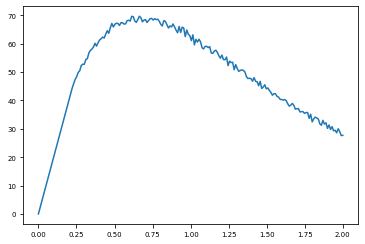

In [24]:
plt.plot(np.linspace(0,2,200), fixed_spread_rewards)

## Finding the best fixed strategy with CMA-ES

/opt/miniconda3/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: input x0 should be a list or 1-D array, trying to flatten (2, 1)-array ()
  warnings.warn(msg + ' (' +


covariance matrix adaptation turned off
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=1065132, Thu May 19 15:05:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 -5.911369210893209e+01 1.0e+00 7.93e-01  8e-01  8e-01 0:02.1
    2     12 -6.898082616679018e+01 1.0e+00 7.37e-01  7e-01  7e-01 0:04.3
    3     18 -6.325064416814135e+01 1.0e+00 6.27e-01  6e-01  6e-01 0:06.4
    5     30 -6.784260961248792e+01 1.0e+00 1.07e+00  1e+00  1e+00 0:10.7
    7     42 -6.705743490479171e+01 1.0e+00 5.75e-01  6e-01  6e-01 0:14.9
   10     60 -6.925260145657423e+01 1.0e+00 3.26e-01  3e-01  3e-01 0:21.3
   13     78 -6.833227842914972e+01 1.0e+00 3.27e-01  3e-01  3e-01 0:27.7
   17    102 -6.817402066550177e+01 1.0e+00 2.77e-01  3e-01  3e-01 0:36.2
   21    126 -6.927530840362080e+01 1.0e+00 2.14e-01  2e-01  2e-01 0:44.7
   26    156 -6.927160110070248e+01 1.0e+00 7.10e-02  7e-02  7e-02 0:55.3
   31    186 -6.958148703005867e+01 1.0e+00 6.49e-02  6e-

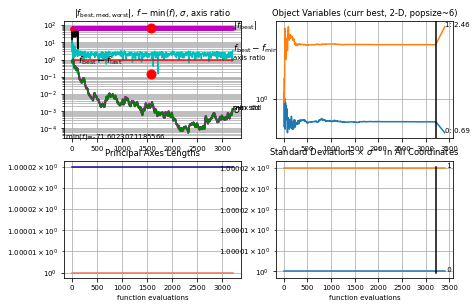

In [25]:
import cma

x0 = [1]
sigma0 = 1
es = cma.CMAEvolutionStrategy(2 * [x0], sigma0, {'CMA_on':0})
es.optimize(lambda x:fixed_strat_neg_reward(x[0])) # on the fly 2-D -> 1-D wrapper
es.logger.plot(xsemilog=True)

In [26]:
es.result_pretty()

termination on tolstagnation=146
final/bestever f-value = -6.835969e+01 -7.160231e+01
incumbent solution: [0.6870811162374137, 2.46124614841121]
std deviation: [0.0013385808531999248, 0.0013386143181395647]


CMAEvolutionStrategyResult(xbest=array([0.68012694, 2.4694063 ]), fbest=-71.6023071185566, evals_best=1583, evaluations=3210, iterations=535, xfavorite=array([0.68708112, 2.46124615]), stds=array([0.00133858, 0.00133861]), stop={'tolstagnation': 146})

In [27]:
as_agent = AvellanedaStoikovAgent(risk_aversion=0)
as_action = as_agent.get_action([0,0,0,0])[0]
cma_action = es.result.xbest[0]
print(f"Optimal strategy is {as_action, as_action}\nCMA-ES strategy is {cma_action,cma_action}")

Optimal strategy is (0.6666666666666666, 0.6666666666666666)
CMA-ES strategy is (0.680126943269561, 0.680126943269561)


In [28]:
print(f"Error is {round(abs(cma_action-as_action)/as_action*100, 2)}%")

Error is 2.02%
